# Analyze Montage MPI

## Global Configurations

In [1]:
notebook_name = "montage-mpi"

In [2]:
parquet_folder="/p/gpfs1/iopp/parquet_app_logs/montage/nodes-32"

In [3]:
num_nodes = 32

## System Imports

In [4]:
import socket
import os
import time
from time import sleep

## Create Dask Cluster for analysis

### Dask Job Queue Imports

In [5]:
import dask_jobqueue
from dask_jobqueue import LSFCluster

/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


### Dask Worker configuration
When we use dask for analysis, we need to consider the type of analysis. In this case we plan to utilize dask dataframes for analysis that is typically memory intensive. Therefore, we allocate the whole memory per node and use only 4 worker processes per node. More worker processes reduce memory available per worker resulting in frequent memory swap from filesystem.

In [6]:
node_memory = 256 # node memory in GB
n_workers_per_node = 4 # number of worker processes per node
worker_time = "01:00" # job time per node for worker
worker_queue = "pbatch" # queue to be used per worker
n_workers = 32 # number of workers to be used for analysis

Other configurations we can compute

In [7]:
host = socket.gethostname()
dashboard_address = '{}:8787'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
job_extra = ['-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time), 
             '-o {}.log'.format(notebook_name), 
             '-e {}.log'.format(notebook_name)]

### Create Dask Cluster 

In [8]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'], 
                     job_extra = job_extra, 
                     use_stdin=True, host = host,dashboard_address = dashboard_address)
if cluster:
    print("Created Cluster with job script\n {}".format(cluster.job_script()))

{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen709', 'dashboard_address': 'lassen709:8787', 'security': None}}
Created Cluster with job script
 #!/usr/bin/env bash

#BSUB -J dask-worker
#BSUB -nnodes 1
#BSUB -G asccasc
#BSUB -q pbatch
#BSUB -W 01:00
#BSUB -o montage-mpi.log
#BSUB -e montage-mpi.log
JOB_ID=${LSB_JOBID%.*}

/usr/workspace/iopp/.conda/envs/jupyter/bin/python -m distributed.cli.dask_worker tcp://192.168.66.201:39125 --nthreads 1 --nprocs 4 --memory-limit 59.60GiB --name name --nanny --death-timeout 60



/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45395 instead
  warnings.warn(


### Dask Analysis Imports

In [9]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

### Create Dask Client

In [10]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.201:45395/status,
Dashboard: http://192.168.66.201:45395/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.201:39125,Workers: 0
Dashboard: http://192.168.66.201:45395/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Spawn cluster nodes

In [11]:
cluster.scale(n_workers)

In [12]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val < n_workers_per_node)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 2 of 32
6 workers started


## Analysis Utility Functions

### Progress Bars

In [13]:
pbar = ProgressBar()
pbar.register()

### Timer functions

In [14]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

### Threading process 

In [15]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

### Application Logs in Parquet format

## Initial Boostrapping

### Read Application logs into dask dataframe

In [16]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [17]:
print("Dask dataframe is split into {} partitions".format(ddf.npartitions))

Dask dataframe is split into 1096 partitions


In [18]:
print("Columns present in dataset")
print(ddf.columns)

Columns present in dataset
Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'hostname', 'arg_count', 'app', 'args_1', 'args_2', 'args_3',
       'args_4', 'args_5', 'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')


In [19]:
ddf.head()

,index,rank,thread_id,cat,tstart,tend,func_id,level,hostname,arg_count,...,args_1,args_2,args_3,args_4,args_5,args_6,args_7,args_8,args_9,args_10
0,1,0,317888,2,2377.614502,2377.614502,MPI_Comm_size,0,lassen70,2,...,MPI_COMM_WORLD,39,,,,,,,,
1,2,0,317888,2,2377.614502,2377.614502,MPI_Comm_rank,0,lassen70,2,...,MPI_COMM_WORLD,0,,,,,,,,
2,3,0,317888,0,2377.618164,2377.618652,fopen64,0,lassen70,2,...,/p/gpfs1/iopp/temp/montage/2854964/17/run/Ktem...,rb,,,,,,,,
3,4,0,317888,0,2377.618896,2377.618896,fread,0,lassen70,4,...,%p,1,2,/p/gpfs1/iopp/temp/montage/2854964/17/run/Ktem...,,,,,,
4,5,0,317888,0,2377.618896,2377.619385,fclose,0,lassen70,1,...,/p/gpfs1/iopp/temp/montage/2854964/17/run/Ktem...,,,,,,,,,


#### Only keep level zero from MPI and FTRACE but keep all levels for I/O

In [20]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

### Split dataframe into I/O, MPI, and trace

In [21]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

### Preload the I/O dataframe for faster analysis

In [22]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Check I/O interfaces used by application

In [23]:
interfaces = io_ddf['func_id'].unique().compute()
print(interfaces)

0       fopen64
1         fread
2        fclose
3     __xstat64
4         fseek
5        remove
6        fwrite
7          open
8          read
9         close
10       access
11        write
Name: func_id, dtype: object


Only POSIX interface is used in this application

### Set duration of I/O events

In [24]:
io_ddf['duration'] = io_ddf['tend'] - io_ddf['tstart']

In [25]:
negetive_duration = io_ddf[io_ddf['duration'] < 0]['duration'].count().compute()
print("Application Profiler has stored {} negetive values".format(negetive_duration))

Application Profiler has stored 0 negetive values


### Create conditions for filtering
Even though this application doesnt have MPI or STDIO we have all the conditions here. This is to make sure we cover other apps as well.

In [26]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

### Extract Filename from each row.
This simplifies analysis later on as we can filter recorder per rank and per file to understand access pattern information.

In [27]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

Some filename has redundent forward slashes

In [28]:
io_ddf['filename'] = io_ddf['filename'].str.replace('//','/')

### Filter recorder which have read and write operations and which have metadata.
We assume that there is only two types of operation in I/O read/write and metadata.

In [29]:
io_ddf_read_write = io_ddf[read_condition | write_condition | fread_condition | fwrite_condition].compute()
io_ddf_metadata = io_ddf[~read_condition & ~write_condition & ~read_condition & ~fwrite_condition].compute()

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 914)": ['tcp://192.168.65.73:37921'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 1051)": ['tcp://192.168.65.73:37921'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 350)": ['tcp://192.168.65.73:35999'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 574)": ['tcp://192.168.65.73:35999'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 506)": ['tcp://192.168.65.73:35999'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 154)": ['tcp://192.168.65.73:35999'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 448)": ['tcp://192.168.65.73:35999'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 864)": ['tcp://192.168.65.73:37921'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 738)": ['tcp://192.168.65.73:35999'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 508)": ['tcp://192.168.65.73:37921'], "('getitem-18e65c369b55ab1adc8bdd05e0486bf6', 949)": ['tcp://192.168.65.73:35999'], "('getitem-18e65c369b

### Build size and count to understand I/O on the io_ddf_read_write dataframe

In [30]:
open_condition = io_ddf_read_write['func_id'].str.contains("open")
mpi_condition = io_ddf_read_write['func_id'].str.contains("MPI")
read_condition = io_ddf_read_write['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf_read_write['func_id'].isin(["fread"])
close_condition = io_ddf_read_write['func_id'].str.contains('close')
write_condition = io_ddf_read_write['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf_read_write['func_id'].isin(["fwrite"])
readdir_condition = io_ddf_read_write['func_id'].isin(["readdir"])

In [31]:
io_ddf_read_write['size'] = 0
io_ddf_read_write['count'] = 1
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(read_condition , io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fread_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fread_condition, io_ddf_read_write['args_2'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(write_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fwrite_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fwrite_condition, io_ddf_read_write['args_2'])

#### Corner cases

In [32]:
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(readdir_condition , "0")
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(readdir_condition , "1")

#### Set Datatypes
This is needed as by default args are string from which they are set.

In [33]:
io_ddf_read_write = io_ddf_read_write.astype({'size': 'int32','count': 'int32'})

#### Compute Final Size
After this point we do not use count field.

In [34]:
io_ddf_read_write['size'] = io_ddf_read_write['size'] * io_ddf_read_write['count']

### Calculate Bandwidth in MB/s for I/O operations.
Durations might be incorrect or equal to zero due to profilers resolution issues. Therefore, we do bandwidth calculations for only correct durations.

In [35]:
correct_dur = ((io_ddf_read_write['tend'] - io_ddf_read_write['tstart']) > 0)
io_ddf_read_write['bandwidth'] = 0
io_ddf_read_write['bandwidth'] = io_ddf_read_write['bandwidth'].mask(correct_dur, io_ddf_read_write['size']*1.0/(io_ddf_read_write['tend'] - io_ddf_read_write['tstart'])/1024.0/1024.0)

### Calculate all relevent filenames in the application
The profiler might see jsrun files and other irrelevant internal files which we filter here.

In [36]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [37]:
print("The application accesses {} files across all ranks".format(len(all_filenames)))

The application accesses 1040 files across all ranks


### Distribution of Transfer Size and Bandwidth in the application
The transfer size is given by the size column in bytes and the bandwidth is shown in MB/s

In [38]:
io_ddf_read_write[['size', 'bandwidth']].describe()

,size,bandwidth
count,5.573336e+06,5.573336e+06
mean,1.026816e+04,9.243302e+00
std,2.647887e+04,6.499922e+01
min,1.000000e+00,0.000000e+00
25%,2.880000e+03,0.000000e+00
50%,2.880000e+03,0.000000e+00
75%,8.776000e+03,0.000000e+00
max,4.620683e+06,1.533146e+04


### Preload the I/O dataframe for faster analysis

In [39]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

## Application Analysis

### Num Ranks

In [40]:
num_ranks = io_ddf_read_write['rank'].nunique()
print("Number of ranks in application {}".format(num_ranks))

Number of ranks in application 39


### Total I/O amount

In [41]:
total_io = io_ddf_read_write.groupby('func_id')['size'].sum()/1024.0/1024.0/1024.0
print("Total I/O in application {} GB".format(total_io.sum()))
print("Total I/O per operation in application {} GB".format(total_io))

Total I/O in application 53.29765773192048 GB
Total I/O per operation in application func_id
fread     27.925529
fwrite    25.372112
read       0.000005
write      0.000011
Name: size, dtype: float64 GB


### I/O per rank

In [42]:
io_ddf_read_write.groupby(['rank', 'func_id'])['size'].sum()

rank  func_id
0     fread      2.613331e+10
      fwrite     3.836587e+08
      read       5.760000e+03
      write      1.152000e+04
1     fread      2.458486e+08
                     ...     
36    fwrite     7.074325e+08
37    fread      1.766825e+08
      fwrite     7.074325e+08
38    fread      1.676681e+08
      fwrite     6.844365e+08
Name: size, Length: 80, dtype: float64

**rank 0 performs 100x more I/O than others. Also every other process reads data where as only rank 0 writes it.**

<AxesSubplot:xlabel='rank'>

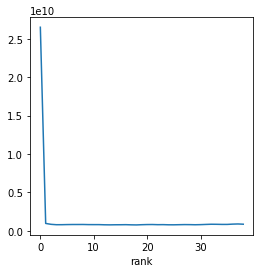

In [43]:
io_per_rank_gb = io_ddf_read_write.groupby(['rank'])['size'].sum()
io_per_rank_gb.plot(kind='line',figsize=(4,4))

### Operations Per Rank

<AxesSubplot:xlabel='rank'>

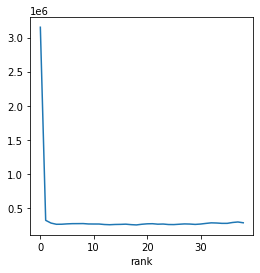

In [44]:
io_per_rank_gb = io_ddf_read_write.groupby('rank')['count'].sum()
io_per_rank_gb.plot(kind='line',figsize=(4,4))

**Also rank 0 performs 2000x more operations than other ranks.**

### Average I/O Time per process

In [45]:
time_per_rank = io_ddf_read_write.groupby('rank')['duration'].sum()

In [46]:
print("time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

time per process: Average 2.3019721508026123 sec, Max 20.9058837890625 sec, and Min 1.50634765625 sec


<AxesSubplot:xlabel='rank'>

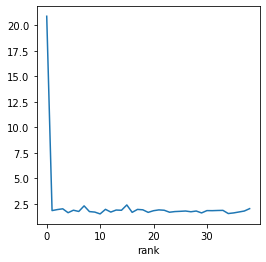

In [47]:
time_per_rank.plot(kind='line',figsize=(4,4))

Most time is spent by rank 0.

### Compute Time

#### Convert trace dataframe into memory.

In [48]:
trace_ddf.head()

,index,rank,thread_id,cat,tstart,tend,func_id,level,hostname,arg_count,...,args_1,args_2,args_3,args_4,args_5,args_6,args_7,args_8,args_9,args_10


In [49]:
trace_ddf_local = trace_ddf

#### Calculate duration for trace values

In [50]:
trace_ddf_local['duration'] = trace_ddf_local['tend'] - trace_ddf_local['tstart']

In [51]:
#trace_ddf_local['duration'].describe().compute()

In [52]:
negetive_durations = trace_ddf_local[trace_ddf_local['duration'] < 0]['duration'].count().compute()
print("Profiler stored {} negetive rows".format(negetive_durations))

Profiler stored 0 negetive rows


In [53]:
time_per_rank = trace_ddf_local.groupby('rank')['duration'].sum().compute()

In [54]:
print("Time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

Time per process: Average nan sec, Max nan sec, and Min nan sec


<AxesSubplot:xlabel='rank'>

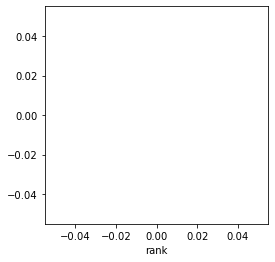

In [55]:
time_per_rank.plot(kind='line',figsize=(4,4))

**No compute trace available**

## Job Time

In [56]:
job_time = ddf['tend'].max().compute()

In [57]:
print("Job Time in Application {} sec".format(job_time))

Job Time in Application 2478.795654296875 sec


The application run for a long time includes initialization.

## Job Intensity

In [58]:
total_compute = trace_ddf_local.groupby('rank')['duration'].sum().max().compute()
total_io = io_ddf.groupby('rank')['duration'].sum().max().compute()
print("I/O Time: {} sec Compute Time: {} sec".format(total_io, total_compute))

I/O Time: 21.086181640625 sec Compute Time: nan sec


In [59]:
io_intensity=total_io/(total_io + total_compute)
comp_intensity=total_compute/(total_io + total_compute)

In [60]:
print("I/O intensity: {}, Compute intensity: {}".format(io_intensity, comp_intensity))

I/O intensity: nan, Compute intensity: nan


**Application is not compute intensive as only 4 second of the overall time (i.e. 668 sec) is spent on I/O**

### I/O Transfer Size Distribution

[3639395, 1740328, 193583, 30, 0]


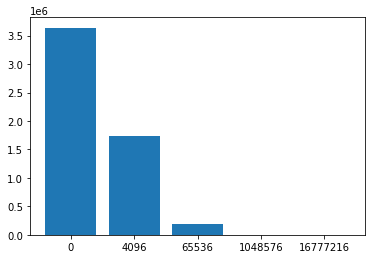

In [61]:
file_df_temp = io_ddf_read_write
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
size_ranges_str = []
for range_val in size_ranges:
    size_ranges_str.append(str(range_val))
max_range = len(size_ranges)
request_size = [0]*len(size_ranges)
for i, val in enumerate(size_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                       (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
    else:
        request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

print(request_size)
plt.bar(size_ranges_str, request_size)
#file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
#plt.hist(file_sizes, bins=100)
plt.show()

**Application performs a lot of small I/O <=4 KB and reads 16MB**

### Distribution of request sizes per rank
We need this as we see most I/O occurs by rank 0

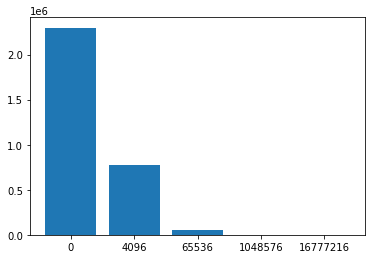

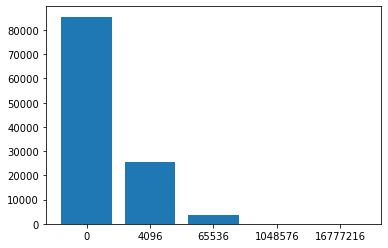

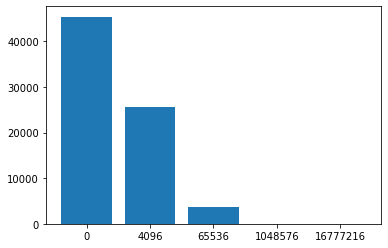

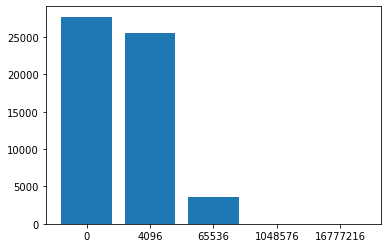

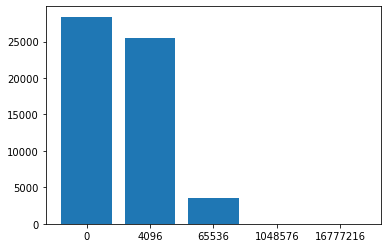

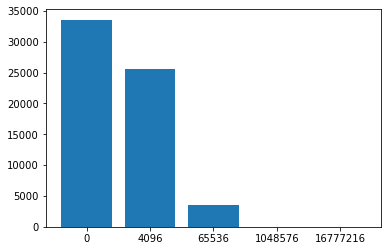

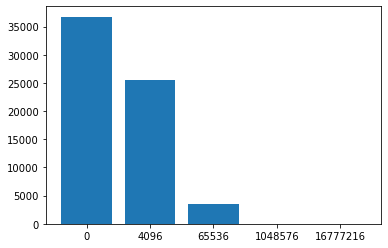

In [62]:
selected_ranks = [0,1,2,3,4,5,6]
for rank in selected_ranks:
    file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
    size_ranges_str = []
    for range_val in size_ranges:
        size_ranges_str.append(str(range_val))
    max_range = len(size_ranges)
    request_size = [0]*len(size_ranges)
    for i, val in enumerate(size_ranges):
        #print(i, max_range)
        if i < max_range - 1:
            request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
        else:
            request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

    #print(request_size)
    plt.bar(size_ranges_str, request_size)
    #file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    #plt.hist(file_sizes, bins=100)
    plt.show()

**The application uses a transfer size of 4K (used by rank 0) and 16MB (used by other ranks)**

### Distribution of Bandwidth achived by application

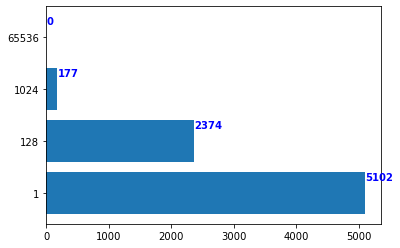

In [63]:
bw_ranges = [1, 128, 1024, 1024*64]
bw_ranges_str = []
for range_val in bw_ranges:
    bw_ranges_str.append(str(range_val))
max_range = len(bw_ranges)
request_bw = [0]*len(bw_ranges)
for i, val in enumerate(bw_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'].ge(val)) & 
                                       (file_df_temp['bandwidth'].lt(bw_ranges[i+1]))]['size'].count()
    else:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'] >=bw_ranges[i])]['size'].count()
fig, ax = plt.subplots()
ax.barh(bw_ranges_str, request_bw)
for i, v in enumerate(request_bw):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

In [64]:
request_bw

[5102, 2374, 177, 0]

In [65]:
percentage_bw = np.array(request_bw)*100/np.sum(request_bw)
percentage_bw

array([66.66666667, 31.02051483,  2.3128185 ,  0.        ])

- 40% of the overall I/O got a bandwidth of 128 MB/s per process.
- 35% achieve a low bandwidth of 64GB/s

0.39316031248303235 nan


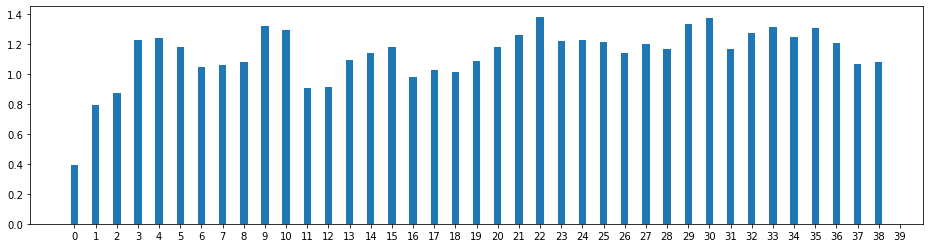

6.687290226239648 nan


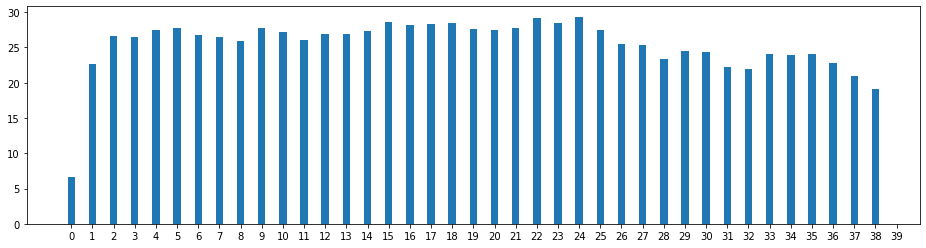

84.52107154994334 nan


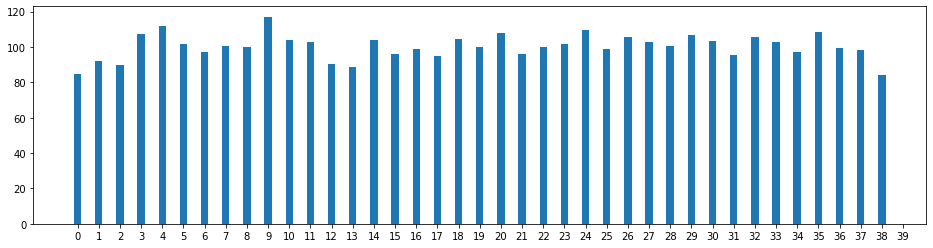

8169.367243923611 nan


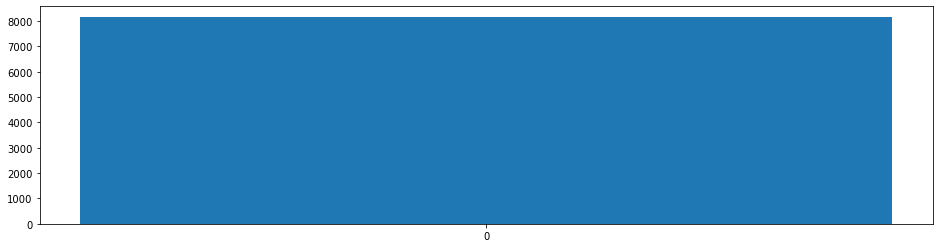

nan nan


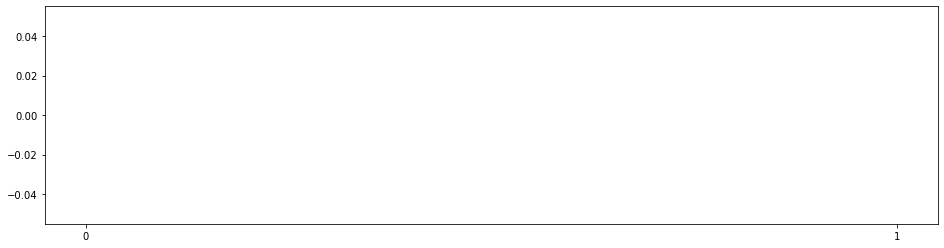

No handles with labels found to put in legend.


In [66]:
ranks = range(40)
ranks_str = []
for rank in ranks:
    ranks_str.append(str(rank))
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(ranks)
    for j,rank in enumerate(ranks):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(request_size[i][0],np.mean(request_size[i]))
    rects1 = plt.bar(ranks_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

### Number of files read/written

In [67]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()
print("The application accesses {} files".format(len(all_filenames)))
#print(all_filenames[:8],all_filenames[-8:])

The application accesses 1040 files


### I/O Operations by Application

In [68]:
io_ddf.groupby('func_id')['func_id'].count().compute()

func_id
__xstat64       1066
access             4
close              6
fclose         11332
fopen64        13388
fread        4464646
fseek           1066
fwrite       1108684
open               6
read               2
remove             4
write              4
Name: func_id, dtype: int64

**As there are 1280 ranks in total, Most I/O is performed by rank 0 rest of them do less I/O**

### IO Operations per app

In [69]:
io_ddf.groupby(['app','func_id'])['func_id'].count().compute()

app      func_id  
mAddMPI  __xstat64       1066
         access             4
         close              6
         fclose         11182
         fopen64        13238
         fread        1356712
         fseek           1066
         fwrite       1108654
         open               6
         read               2
         remove             4
         write              4
mViewer  fclose           150
         fopen64          150
         fread        3107934
         fwrite            30
Name: func_id, dtype: int64

In [70]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[32:40]

rank  func_id  
4     fopen64        328
      fread        28418
      fseek           28
      fwrite       29110
5     __xstat64       28
      fclose         286
      fopen64        332
      fread        33586
Name: func_id, dtype: int64

**These confirm our hypothesis that most I/O is performed by rank 0 rest of them do less I/O**

### Bandwidth per request distribution
We calculate the achived bandwidth per request size.

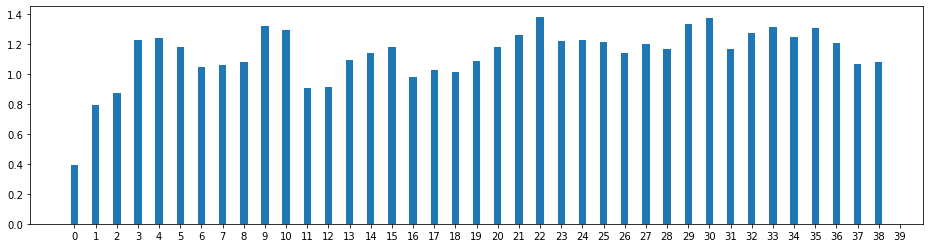

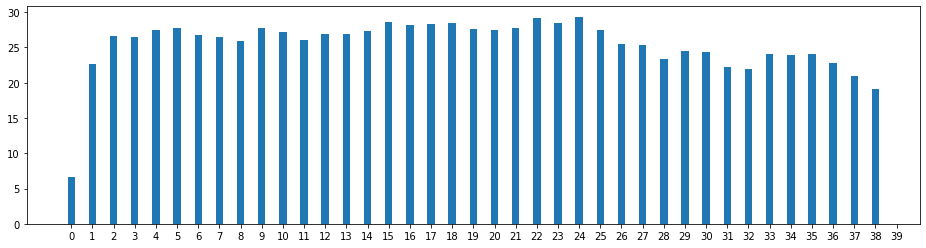

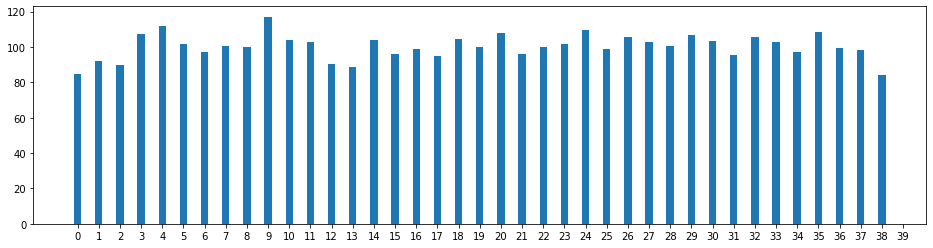

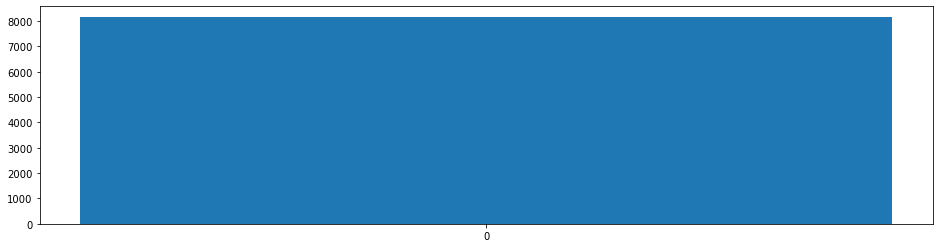

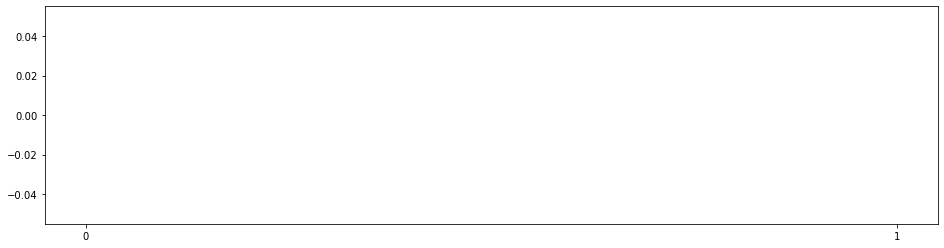

No handles with labels found to put in legend.


In [71]:
ranks = range(40)
ranks_str = []
for rank in ranks:
    ranks_str.append(str(rank))
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(ranks)
    for j,rank in enumerate(ranks):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    rects1 = plt.bar(ranks_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

**Larger Request sizes have larger bandwidth. However as 4KB write dominates the application I/O we see small bandwidth overall**

### Overlapping of Compute and I/O

In [72]:
io_ddf.groupby('rank')['thread_id'].nunique().describe().compute()

count    39.000000
mean      1.025641
std       0.160128
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: thread_id, dtype: float64

#### No additional threads means I/O is synchronous to compute. I.e. all I/O is unoverlapped.

### Timeline
The timeline analysis shows how each rank performs I/O over the runtime of the applications

In [73]:
time_step=10 # in seconds

#### Request Size Timeline

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.37491798400879, 250.05436897277832, 224.12839889526367, 159.7985610961914, 121.50543022155762, 122.51662635803223, 252.45293807983398, 268.1871585845947, 226.09140014648438, 135.23506927490234, 143.47812461853027, 148.0019416809082, 164.15448379516602, 113.17378997802734, 102.54543495178223, 126.38769149780273, 160.00070190429688, 147.57668113708496, 142.15917015075684, 118.02712821960449, 108.24637222290039, 118.80501937866211, 170.56968688964844, 197.60701370239258, 191.93951797485352, 204.41419410705566, 200.1758213043213, 169.01627159118652, 191.06605339050293, 194.65034103393555, 154.3903465270996, 174.74551391601

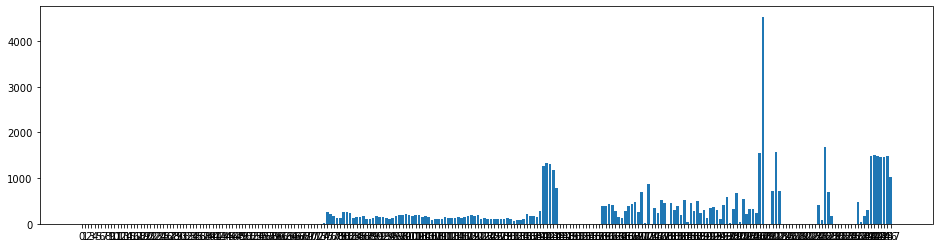

In [74]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0
    prev = values[i]
print(timeline_ts)
plt.figure(figsize=(16,4))
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.540353775024414, 35.647966384887695, 57.35972213745117, 45.67578887939453, 52.42422294616699, 49.06789588928223, 13.760425567626953, 39.39431190490723, 85.91871643066406, 37.908409118652344, 58.27435874938965, 61.935550689697266, 49.998905181884766, 34.975059509277344, 47.61760902404785, 56.2940788269043, 61.28184509277344, 32.90138816833496, 44.18434715270996, 43.21206474304199, 27.196720123291016, 44.26400375366211, 34.38728332519531, 11.903736114501953, 68.13733291625977, 49.37540626525879, 58.23038673400879, 55.87930870056152, 37.12013053894043, 40.70441818237305, 39.25973129272461, 43.725677490234375, 65.5610351562

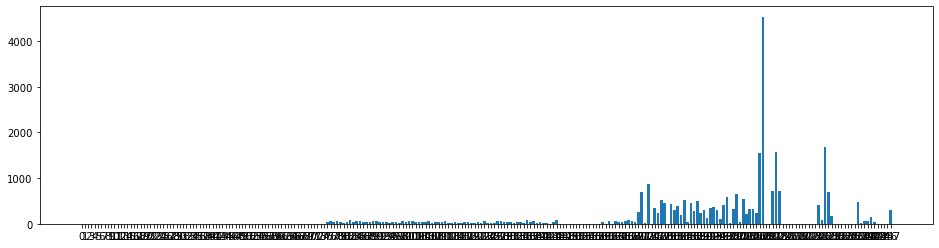

In [75]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fread_condition
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0
    prev = values[i]
print(timeline_ts)
plt.figure(figsize=(16,4))
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.834564208984375, 214.40640258789062, 166.7686767578125, 114.12277221679688, 69.08120727539062, 73.44873046875, 238.69251251220703, 228.7928466796875, 140.1726837158203, 97.32666015625, 85.20376586914062, 86.06639099121094, 114.15557861328125, 78.19873046875, 54.927825927734375, 70.09361267089844, 98.71885681152344, 114.67529296875, 97.97482299804688, 74.8150634765625, 81.04965209960938, 74.541015625, 136.18240356445312, 185.70327758789062, 123.80218505859375, 155.03878784179688, 141.9454345703125, 113.136962890625, 153.9459228515625, 153.9459228515625, 115.130615234375, 131.01983642578125, 86.11331176757812, 67.9870605

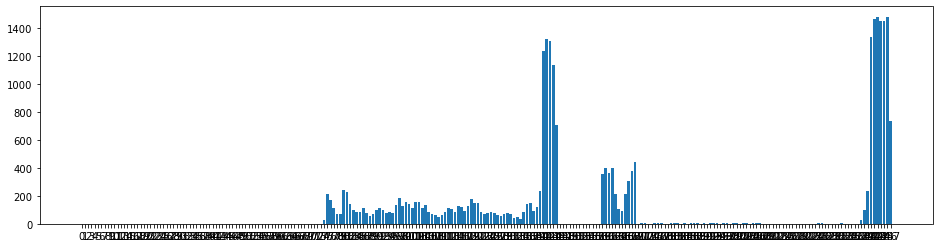

In [76]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fwrite_condition
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0
    prev = values[i]
print(timeline_ts)
plt.figure(figsize=(16,4))
plt.bar(values_str, timeline_ts)
plt.show()

**Most of the I/O (20GB) is performed in first 40 seconds and rest 1GB happens in the rest of the time**

### Time Timeline

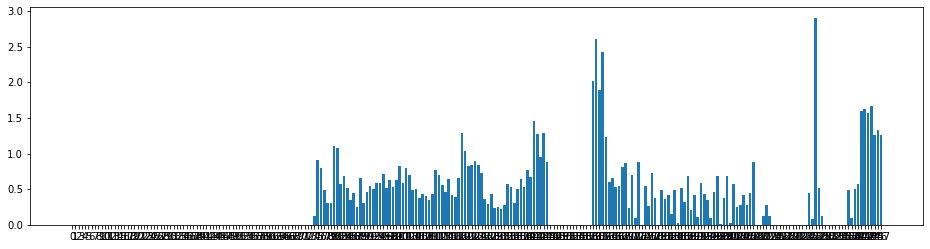

In [77]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['duration'].sum()
    prev = values[i]
plt.figure(figsize=(16,4))
plt.bar(values_str, timeline_ts)
plt.show()

#### Bandwidth Timeline

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 3.453639994310092, 3.6259505208575136, 2.2831823018949517, 1.9290941720341095, 1.3147539814209623, 1.5454363120504673, 5.855972188556668, 3.8431744117297613, 1.278454227200059, 2.159399741395297, 1.413122538396278, 0.9738438984112021, 1.4080056184733174, 1.2261432422395442, 0.8475539048092873, 0.9017672025700495, 1.3071967358363832, 2.0558641630054137, 1.6070952384986097, 1.0624369985796391, 1.609302569679064, 1.1605227977586354, 2.5293800584085635, 5.12112393729361, 1.4720486635905967, 2.343017405231992, 2.104906969084509, 1.60333407755687, 2.437820818939698, 1.2774270403157435, 0.4275673711203175, 0.5311345173801609, 0.

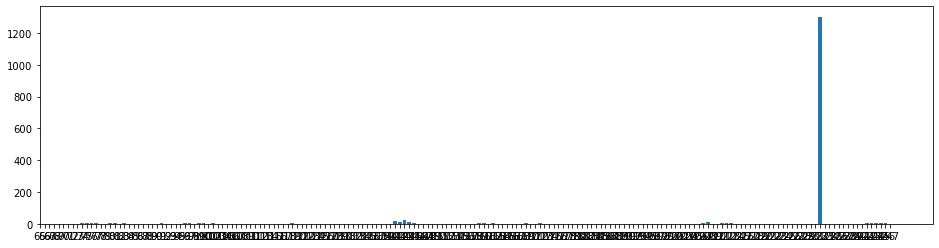

In [78]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/10.0
    prev = values[i]
print(timeline_ts)
plt.figure(figsize=(16,4))
plt.bar(values_str, timeline_ts)
plt.show()

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2051802504078295, 0.2551221207378087, 0.21008614144194143, 0.2371903751340015, 0.2330171103376062, 0.23951772438069088, 0.22175772786441322, 0.2160967835841105, 0.22114932206377413, 0.23352916621687383, 0.22052121322326607, 0.22038291519822173, 0.21352249082193103, 0.20965527858242478, 0.2151282107849645, 0.21804918046819638, 0.22937576848753008, 0.2253820470548368, 0.22064793134582805, 0.22269744991539198, 0.21409692994474355, 0.23443723059018257, 0.21098870038875278, 0.24084662220356018, 0.20814336405928832, 0.23737965855141505, 0.22585743938737585, 0.21657037262693107, 0.2568505972013126, 0.12072876219308301, 0.05349

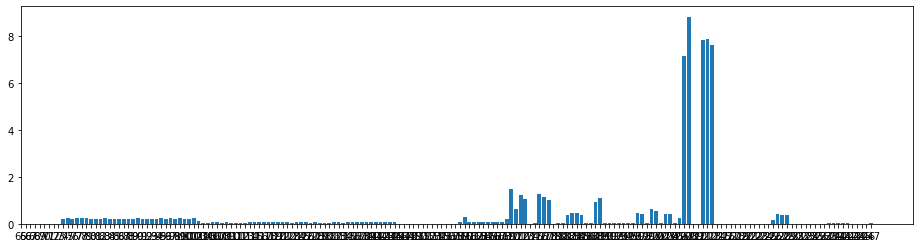

In [79]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fread_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/10.0
    prev = values[i]
print(timeline_ts)
plt.figure(figsize=(16,4))
plt.bar(values_str, timeline_ts)
plt.show()

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 5.299712417941857, 5.768614474846599, 5.0076668240870905, 5.405335048204647, 6.90183615819209, 7.484854504048583, 7.493337531279629, 6.970355195152564, 3.896582326682208, 4.120105916683562, 3.545100247533051, 2.402438264301943, 2.7892212350676733, 2.416455119036709, 2.2765074404761907, 2.3328016868512114, 3.0270354715803647, 3.4042744569979284, 3.2083694089392774, 2.275906785935116, 2.781133781547211, 2.5362024794292717, 5.470692730805416, 6.697272759056027, 4.965202043650794, 4.651179405028373, 4.6121151242846405, 3.837315005268027, 4.166526689433385, 2.282469321973432, 0.7929776543988483, 0.9459382532174082, 0.726131521

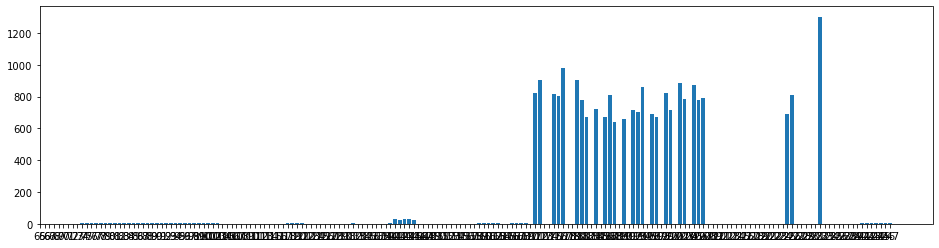

In [80]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fwrite_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/10.0
    prev = values[i]
print(timeline_ts)
plt.figure(figsize=(16,4))
plt.bar(values_str, timeline_ts)
plt.show()

**This supports our previous observation as the bandwidth is the measure of I/O performance of the application.**

In [85]:
io_ddf_read_write[io_ddf_read_write['func_id'].str.contains("read")].groupby(['app','func_id'])['size'].sum()/1024.0/1024.0

app      func_id
mAddMPI  fread       3715.484825
         read           0.005493
mViewer  fread      24880.257133
Name: size, dtype: float64

In [87]:
io_ddf_read_write[io_ddf_read_write['func_id'].str.contains("write")].groupby(['app','func_id'])['size'].sum()/1024.0/1024.0

app      func_id
mAddMPI  fwrite     25865.499470
         write          0.010986
mViewer  fwrite       115.543610
Name: size, dtype: float64

#### Bandwidth Timeline Per App

In [81]:
selected_app = io_ddf_read_write['app'].unique()

app mAddMPI


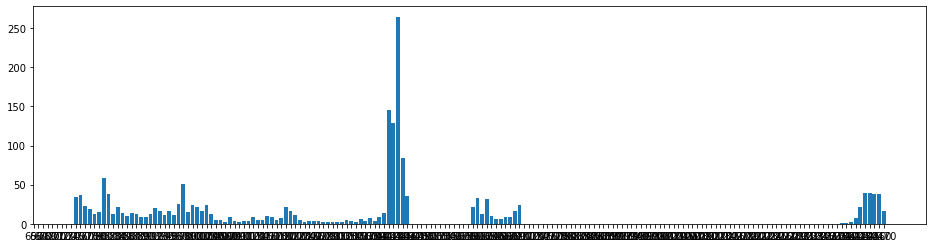

app mViewer


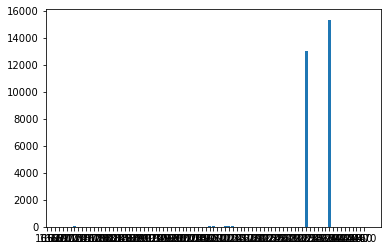

In [82]:
import math

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_app = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(values[i]))
        contains = (io_df_app['tstart'] >=prev) & (io_df_app['tend'] <values[i])
        timeline_ts[i] = io_df_app[contains]['bandwidth'].mean()
        prev = values[i]
    print("app {}".format(app))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Most I/O happens in the first 40 sec and most bandwidth is achieved from PFS**

#### Request Size Timeline per Rank

app mAddMPI


<Figure size 1152x288 with 0 Axes>

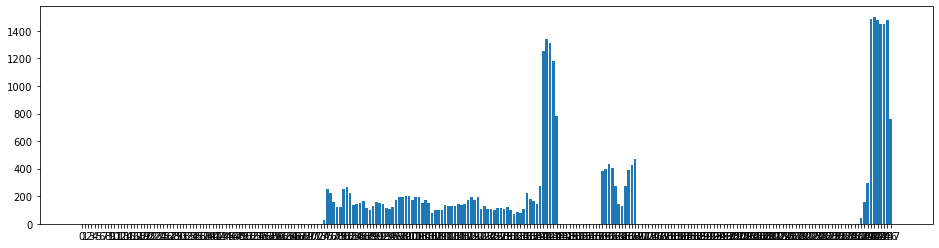

app mViewer


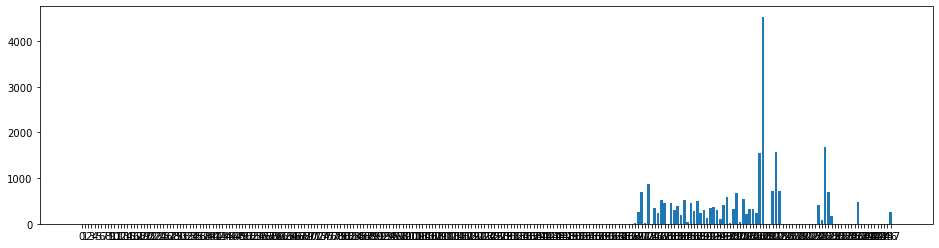

In [83]:
import math

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_app = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(i))
        contains = (io_df_app['tstart'] >=prev) & (io_df_app['tend'] <values[i])
        timeline_ts[i] = io_df_app[contains]['size'].sum()/1024.0/1024.0
        prev = values[i]
    print("app {}".format(app))
    plt.figure(figsize=(16,4))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Only rank 0 does I/O throughout the time. Rest perform read in first 40 seconds and perform computations.** 

## Find file which are independent or shared
- Make all thread id start from 0 and unique across ranks
- Group by filename nunique thread_id
- Find all filename with nunique > 1

In [78]:
thread_index_series = io_ddf.groupby(['rank', 'thread_id'])['thread_id'].nunique().cumsum().compute()

In [79]:
io_ddf['thread_index'] = 0
for index,item in thread_index_series.iteritems():
    condition = (io_ddf['rank'] == index[0]) & (io_ddf['thread_id'] == index[1])
    io_ddf['thread_index'] = io_ddf['thread_index'].mask(condition , item - 1)

In [80]:
threads = io_ddf['thread_index'].nunique().compute()
print("We have {} threads across {} ranks".format(threads, num_ranks))

We have 40 threads across 39 ranks


In [81]:
filename_series = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')].groupby(['filename'])['thread_index'].nunique().compute()

In [82]:
independent_files = filename_series[filename_series == 1]
print("{} files that are accessed by application by only one rank".format(len(independent_files)))

80 files that are accessed by application by only one rank


In [83]:
shared_files = filename_series[filename_series > 1]
print("{} files that are accessed by application by more than one rank".format(len(shared_files)))

960 files that are accessed by application by more than one rank


This application doesnt share files. That is it follows a File per process pattern.

### Data Flow
We plot how different ranks in the job are accessing data.

In [84]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(1)
for selected_index in selected_indices:
    selected_shared_file = shared_files.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_shared_file].groupby(['rank','func_id'])['func_id'].count().compute()
    dot.node(selected_shared_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_shared_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_shared_file, label=str(count))

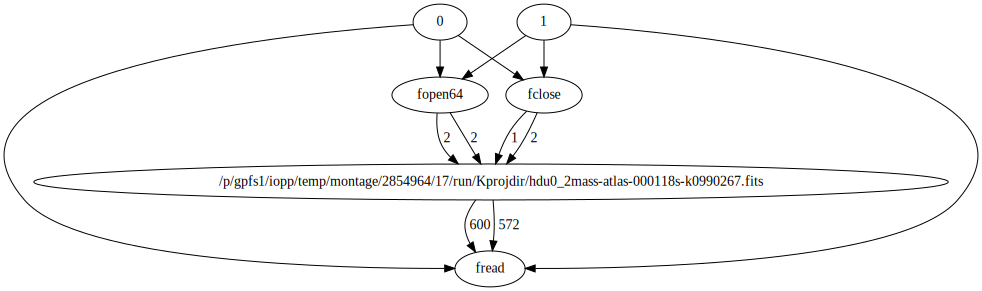

In [85]:
dot

In [86]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    if len(independent_files) > selected_index:
        selected_file = independent_files.index[selected_index]
        io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
        dot.node(selected_file)
        for index,item in io_access_rank.iteritems():
            rank = index[0]
            func_id = index[1]
            count = item
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            else:
                dot.edge(func_id,selected_file, label=str(count))

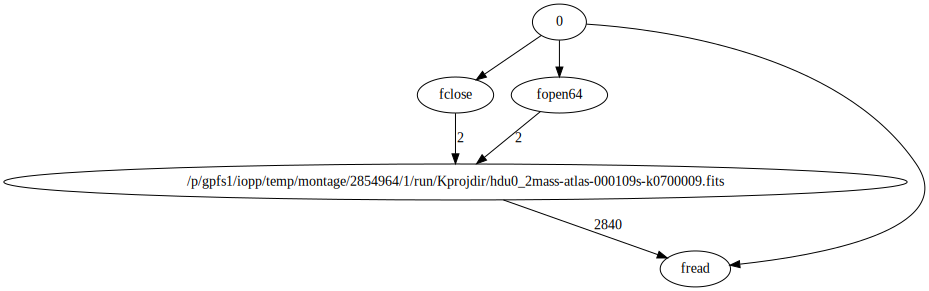

In [87]:
dot

## Calculate Access Pattern
- Calculate segment_index
  - select file_ptr based on open flag
  - update file_ptr based on operation
  - do a cum_sum on file_ptr to calculate final file_ptr
  - assign segment_index based on granularity (median transfer size)
- isolate segment index into
  - sequential flag if segment index is increasing
  - consequitive flag if segment index is increasing and one after the other

#### Persist the current version of I/O dataframe.

In [88]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Select files which have no seeks and those which have

In [89]:
files_with_seek = io_ddf[io_ddf['func_id'].str.contains('seek') & io_ddf['filename'].str.contains('/p/gpfs')]['filename'].unique().compute()
print("{} files have seek operations".format(len(files_with_seek)))

0 files have seek operations


In [90]:
files_with_seek

Series([], Name: filename, dtype: object)

In [91]:
all_filenames

0       /p/gpfs1/iopp/temp/montage/2854964/17/run/Ktem...
1       /p/gpfs1/iopp/temp/montage/2854964/17/run/imag...
2       /p/gpfs1/iopp/temp/montage/2854964/17/run/ngc3...
3       /p/gpfs1/iopp/temp/montage/2854964/17/run/ngc3...
4       /p/gpfs1/iopp/temp/montage/2854964/17/run/Kpro...
                              ...                        
1035    /p/gpfs1/iopp/temp/montage/2854964/0/run/Kproj...
1036    /p/gpfs1/iopp/temp/montage/2854964/0/run/Kproj...
1037    /p/gpfs1/iopp/temp/montage/2854964/30/run/ngc3...
1038    /p/gpfs1/iopp/temp/montage/2854964/30/run/ngc3...
1039    /p/gpfs1/iopp/temp/montage/2854964/31/run/ngc3...
Name: filename, Length: 1040, dtype: object

In [92]:
files_without_seek = set(all_filenames) - set(files_with_seek)
print("{} files have no seek operations and hence are sequential".format(len(files_without_seek)))

1040 files have no seek operations and hence are sequential


### Per File Analysis
- Total I/O amount
- Total I/O time (average per process)
- Average Bandwidth
- I/O Request Distribution

In [93]:
per_file_size = io_ddf_read_write.groupby(['filename'])['size'].sum()
per_file_size = per_file_size / 1024.0/1024.0
per_file_size = per_file_size.sort_values(ascending=False)
per_file_size.head(5)

filename
/p/gpfs1/iopp/temp/montage/2854964/5/run/ngc3372.fits         11953.809086
/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc3372.fits          4761.546556
/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc3372_area.fits     4761.543809
/p/gpfs1/iopp/temp/montage/2854964/25/run/ngc3372.fits         3456.573452
/p/gpfs1/iopp/temp/montage/2854964/5/run/ngc3372_area.fits     2930.511292
Name: size, dtype: float64

In [94]:
per_file_time = io_ddf_read_write.groupby(['filename'])['duration'].sum().sort_values(ascending=False)
per_file_time.head(5)

filename
/p/gpfs1/iopp/temp/montage/2854964/25/run/ngc3372.fits         7.427246
/p/gpfs1/iopp/temp/montage/2854964/25/run/ngc3372_area.fits    5.805176
/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc3372.fits          5.547363
/p/gpfs1/iopp/temp/montage/2854964/5/run/ngc3372.fits          5.317505
/p/gpfs1/iopp/temp/montage/2854964/1/run/ngc3372_area.fits     3.731445
Name: duration, dtype: float32

In [95]:
per_file_bw = io_ddf_read_write.groupby(['filename'])['bandwidth'].sum().sort_values(ascending=True)
per_file_bw.head(5)

filename
/p/gpfs1/iopp/temp/montage/2854964/25/run/Kprojdir/hdu0_2mass-atlas-000119s-k0600021.fits          0.001420
/p/gpfs1/iopp/temp/montage/2854964/1/run/Ktemplate.hdr                                             0.007812
/p/gpfs1/iopp/temp/montage/2854964/11/run/Ktemplate.hdr                                            0.140625
/p/gpfs1/iopp/temp/montage/2854964/25/run/Kprojdir/hdu0_2mass-atlas-000119s-k0600021_area.fits    22.501420
/p/gpfs1/iopp/temp/montage/2854964/17/run/Kprojdir/hdu0_2mass-atlas-000118s-k1000139_area.fits    78.751491
Name: bandwidth, dtype: float64

In [96]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_size.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        if "read" in func_id or "write" in func_id:
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            elif "write" in func_id:
                dot.edge(func_id,selected_file, label=str(count))

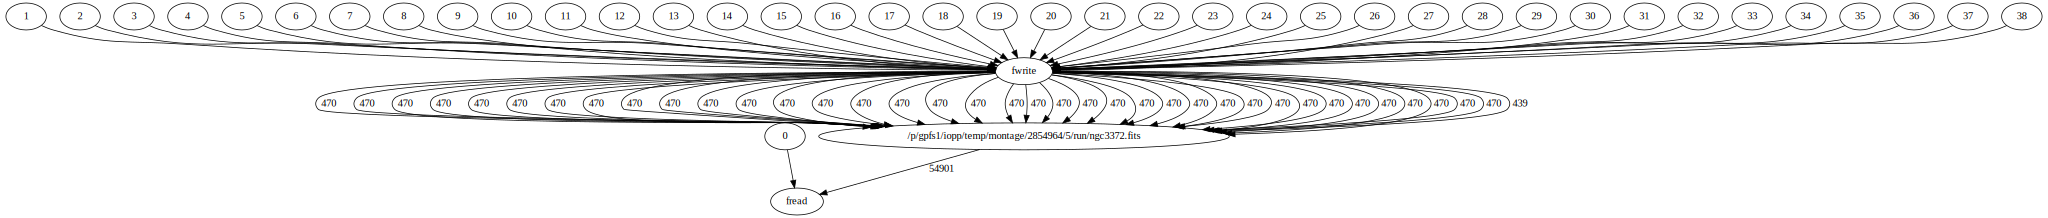

In [97]:
dot

In [98]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_time.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

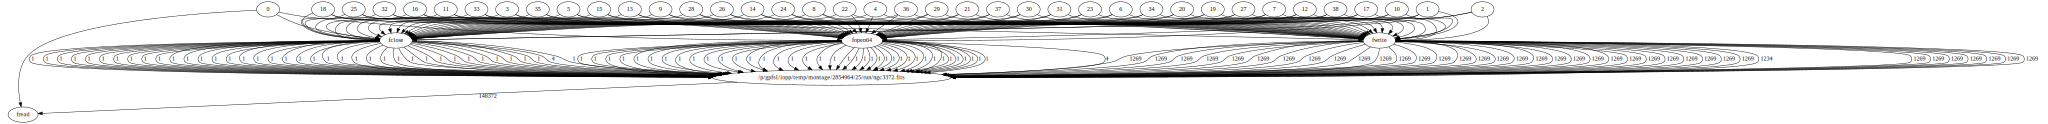

In [99]:
dot

In [100]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(5)
for selected_index in selected_indices:
    if len(per_file_bw) > selected_index:
        selected_file = per_file_bw.index[selected_index]
        io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
        dot.node(selected_file)
        for index,item in io_access_rank.iteritems():
            rank = index[0]
            func_id = index[1]
            count = item
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            else:
                dot.edge(func_id,selected_file, label=str(count))

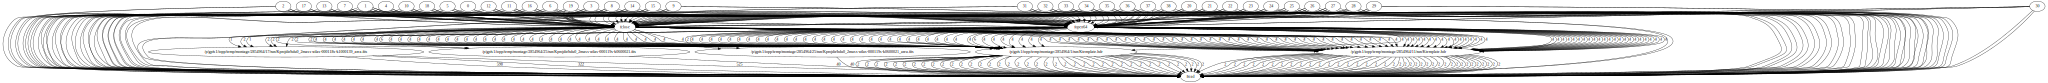

In [101]:
dot

In [102]:
write_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('write')]['filename'].unique()
read_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('read')]['filename'].unique()
read_only_files = set(all_filenames) - set(write_files)
write_only_files = set(all_filenames) - set(read_files)
print("{} files are written into.\n{} file are read from.\n{} files are write-only.\n{} file are read-only."
      .format(len(write_files), len(read_files), len(write_only_files), len(read_only_files)))

86 files are written into.
953 file are read from.
87 files are write-only.
954 file are read-only.


In [103]:
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv","fread"])
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev","fwrite"])
data_ops = ['read', 'write']
total_time_io_data = io_ddf[ read_condition | write_condition ].groupby('rank')['duration'].sum().max().compute()
total_time_io_metadata = io_ddf[~(read_condition | write_condition)].groupby('rank')['duration'].sum().max().compute()
print("Time spent on data: {} sec, metadata: {} sec".format(total_time_io_data, total_time_io_metadata))

Time spent on data: 0.000244140625 sec, metadata: 21.0859375 sec
